# Introduction of Dark Matter: Exercise

In [1]:
%matplotlib widget

In [2]:
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np

## 1 Dark Matter (DM) density profile

### 1.1

In [40]:
r_s = 24.42 # kpc
rho_s = 0.184 # GeV cm^{-3}
r_sun = 8.4 # kpc

In [4]:
def rho_NFW(r):
    """
    Parameters
    ----------
    r : float
        The radius from the GC in kpc.
    
    Returns
    -------
    rho_NFW : float
        The DM density in unit GeV cm^{-3}
    """
    return rho_s * np.power(r/r_s, -1) * np.power(1 + r/r_s, -2)

In [25]:
c = 299792458*u.m/u.s
G = 6.6743e-11*u.m**3/(u.kg*u.s**2) # m^3 kg^{-1} s^{-2}
M_BH = 4.154e6*u.M_sun 
R_sch = 2*G*M_BH/c**2
R_vir = 200*u.kpc
r_min = 2*R_sch
r_min_kpc = r_min.to(u.kpc).value
R_vir_kpc = R_vir.to(u.kpc).value
log10_r_min_kpc = np.log10(r_min_kpc)
log10_R_vir_kpc = np.log10(R_vir_kpc)
r = np.logspace(log10_r_min_kpc, log10_R_vir_kpc, int((log10_R_vir_kpc - log10_r_min_kpc)/0.1))

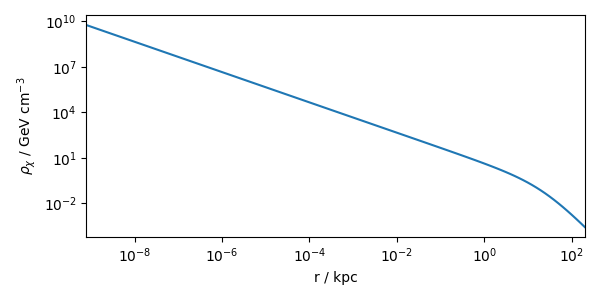

In [24]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot()
ax.plot(r, rho_NFW(r), '-')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'r / kpc')
ax.set_ylabel(r'$\rho_\chi$ / GeV cm$^{-3}$')
ax.set_xlim(r_min_kpc, R_vir_kpc)
fig.tight_layout()
plt.show()

### 1.2

Solve on paper.

In [41]:
def r_of_l_psi(l, psi):
    """Calculates the distance r from the GC given the l-o-s length l and angle
    psi.

    Parameters
    ----------
    l : array of float
        The l-o-s length l in kpc.
    psi : float
        The l-o-s angle psi in radian.

    Returns
    -------
    r : array of float
        The distance r from the GC. 
    """
    return np.sqrt(l**2 - 2*l*r_sun*np.cos(psi) + r_sun**2)

In [39]:
psi = np.deg2rad(0)
l = np.logspace(np.log10(0.1), np.log10(200), int((np.log10(200)-np.log10(0.1))/0.1))
r = r_of_l_psi(l=l, psi=psi)
#print(f'l={l}')
#print(f'r={r}')

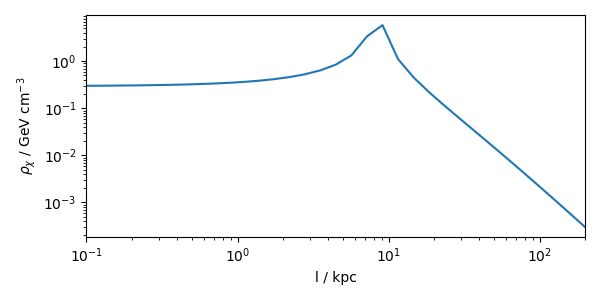

In [37]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot()
ax.plot(l, rho_NFW(r), '-')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'l / kpc')
ax.set_ylabel(r'$\rho_\chi$ / GeV cm$^{-3}$')
ax.set_xlim(np.min(l), np.max(l))
fig.tight_layout()
plt.show()

## 2 J-Factor and flux 

### 2.2

In [42]:
from scipy import integrate

ModuleNotFoundError: No module named 'scipy'

In [ ]:
def rho_chi(r):
    """Calculates the DM density rho_chi given in eq (1).
    
    Parameters:
    -----------
    r : float | array of float
        The distance from the GC in kpc.
    
    Returns
    -------
    rho_chi : array of float
        The DM density in GeV cm^{-3}.
    """
    r = np.atleast_1d(r)
    
    m = (r > 2*R_sch.to(u.kpc).value) & (r <= R_vir.to(u.kpc).value)
    
    rho_chi = np.zeros_like(r)
    rho_chi[m] = rho_NFW(r=r[m])
    
    return rho_chi

def rho_chi_of_l_psi(l, psi):
    r = r_of_l_psi(l=l, psi=psi)
    rho_chi = rho_chi(r=r)
    return rho_chi

def l_integrand(l, psi):
    rho_sun = rho_chi(r=r_sun)[0]
    return 1 / r_sun * np.power(rho_chi(l=l, psi=psi) / rho_sun, 2)

def l_integral(psi, l_min, l_max):
    res = integrate.quad(l_integrand, l_min, l_max, args=(psi,))
    return res[0]